Imports

In [1]:
# Import necessary libraries
from nnsight import LanguageModel
import torch

# Initialize the language model with specific parameters
model = LanguageModel("google/gemma-2b-it", trust_remote_code=True, device_map="auto", low_cpu_mem_usage=True, torch_dtype=torch.float16)
model.requires_grad_(False)

# Download the SAE weights file (commented out)
#!wget -c 'https://huggingface.co/jbloom/Gemma-2b-Residual-Stream-SAEs/resolve/main/gemma_2b_blocks.6.hook_resid_post_16384_anthropic_fast_lr/sae_weights.safetensors?download=true' -O 'sae.safetensors'

# Load the SAE weights using safetensors
from safetensors import safe_open
with safe_open("/home/ashater/work/sae.safetensors", framework="pt") as st:
    w_dec = st.get_tensor("W_dec")

import pandas as pd

Parameters

In [2]:
#@title Self-explanation in 18 lines
feature = 471  #@param {type: "integer"}
#feature = 5892  #@param {type: "integer"}
#feature = 9415
scale = 67.5  #@param {type: "number"}
se_demo = True  #@param {type: "boolean"}
max_new_tokens = 80  #@param {type: "integer"}
n_generate = 1  #@param {type: "integer"}
vals = ['positive', 'neutral', 'negative']
samples = pd.read_excel('/home/ashater/work/sae/sentence_sentiment_gpt4o.xlsx')

Main code


In [5]:
w_dec.shape

torch.Size([16384, 2048])

In [3]:
#from dictionary_learning.dictionary import AutoEncoder
#ae = AutoEncoder.from_pretrained(w_dec)

v = samples[samples.Sentence.map(lambda x: ' rating ' in x)].index.tolist()


In [358]:
full_res = []
#v = range(0,10)
for ismpl in v:
    # prompt = """<start_of_turn>user\nYou are financial analyst providing credit rating. 
    # Can you provide rating for the following sentnece as a financial credit rating, expressed as grades
    # AAA:The highest rating, indicating an extremely strong ability to meet financial commitments, 
    # AA:A very strong ability to meet financial commitments, 
    # A:A strong ability to meet financial commitments, but more susceptible to adverse economic conditions, 
    # BBB:An adequate ability to meet financial commitments, but more subject to adverse economic conditions 
    # BB: Marginal financial security characteristics
    # B: Weak financial security characteristics
    # CC: A default is expected to be a virtual certainty
    # C: Highly vulnerable to nonpayment
    # D: In default or in breach of an imputed promise, provide one rating X 
    # ?""" +  samples.iloc[ismpl].Sentence + '?' + """ <end_of_turn>\n<start_of_turn>model""" 

    # prompt = """<start_of_turn>user\nCan you rate  the following sentnece as a financial credit sentiment, very positive, 
    # somewhat positive, neutral, somewhat negative, 
    # very negative? """ + samples.iloc[ismpl].Sentence +  '<end_of_turn>\n<start_of_turn>model\nThe sentiment of the setence is "X"'

    # prompt = """You are an intelligent AI Assistant and your task is to provide a sentiment for the sentence provided.\
    #     Reply with the sentiment only in one out of these five categories - 'Very Positive', 'Very Negative', 'Neutral', 'Somewhat Positive',
    #    'Somewhat Negative' . No explanation or "." is required. - """ + samples.iloc[ismpl].Sentence

    prompt = """<start_of_turn>user\nYou are an intelligent AI Assistant focused on credit ratings, can you rate  the following sentnece as a financial credit sentiment, very positive, 
    somewhat positive, neutral, somewhat negative, 
    very negative -  """ + samples.iloc[ismpl].Sentence + '<end_of_turn>\n<start_of_turn>model Sentiment of the setneces is:X\n'

    
    # prompt = """<start_of_turn>user\nCan you rate  the following sentnece X as a financial credit sentiment, very positive, 
    # somewhat positive, neutral, somewhat negative, 
    # very negative? """ + samples.iloc[ismpl].Sentence + '<end_of_turn>\n<start_of_turn>model\nThe sentiment of the setence is "X"'
    #prompt = '<start_of_turn>user\nWhat is the meaning of the word "X"?<end_of_turn>\n<start_of_turn>model\nThe meaning of the word "X" is "'
    positions = [i for i, a in enumerate(model.tokenizer.encode(prompt)) if model.tokenizer.decode([a]) == "X"]
    with model.generate(prompt, max_new_tokens=max_new_tokens, num_return_sequences=n_generate, do_sample=False, temperature=0, top_k=1, scan=False, validate=False) as gen:
        # vector = w_dec[[feature]]
        # vector = vector / vector.norm()
        # vector = vector * scale
        # for position in positions:
        #    model.model.layers[2].output[0][:, position] = vector
        vector = sae.W_dec[[feature]]
        vector = vector / vector.norm()
        vector = vector * 55.5
        # setting vector into layer 2
        # for position in positions:        
        
        # model.model.layers[2].output[0][:, :] = vector
        for position in positions:
            model.model.layers[2].output[0][:, position] = vector

        # vector = sae.W_dec[[11912]]
        # vector = vector / vector.norm()
        # vector = vector * 10
        # #setting vector into layer 2
        # # for position in positions:        
        # #    model.model.layers[2].output[0][:, position] += vector
        # model.model.layers[2].output[0][:, :] += vector
        out = model.generator.output.save()
        resid = model.model.layers[6].output.save()
        
    features = sae.encode(resid[0])
    summed_activations = features.abs().sum(dim=1) # Sort by max activations
    top_activations_indices = summed_activations.topk(20).indices # Get indices of top 20    
    res  = { v:0 for v in vals }
    for i, l in enumerate(model.tokenizer.batch_decode(out)):
        s = repr(l.partition(prompt)[2].partition("<eos>")[0])
        print(samples.iloc[ismpl].Sentence+"|"+ s + "|" + str(top_activations_indices))
        # print(str(top_activations_indices))
        for k in res.keys():
            if k in s:
                res[k]+=1
    full_res.append(res)

Its credit rating was slashed to junk status after missing key financial benchmarks.|"**Very negative**\n\nThe credit rating was slashed to junk status, indicating a significant decline in the issuer's creditworthiness and ability to repay debt."|tensor([[  471,  3553, 11912,  5419,  3390, 10859, 15881,  5347,  1630, 16334,
          4579,   556,  5490, 11785,  1587,  5577,  9415,  1491, 15831,  2241]],
       device='cuda:0')
The business failed to meet debt repayment deadlines, leading to a credit rating downgrade.|"**Somewhat negative**\n\nThe sentence indicates a negative impact on the business's credit rating due to missed debt repayments."|tensor([[ 3553,   471, 11912,  5419,  3390, 15881,  4675,  5347,  1630, 10859,
          4579, 16334,   556,  5490, 11785, 13743,  1587,  9415,  5577,  1491]],
       device='cuda:0')
A downgrade of the vehicle’s credit rating has raised its borrowing costs significantly.|"**Somewhat negative**\n\nThe sentence suggests that the vehicle's credit

In [287]:
pd.Series(features[0].mean(axis=0).sort().indices.cpu()).to_clipboard()

In [3]:
 #model.model.layers[6].mlp
# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
from sae_lens import SAE
layer = 6

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-2b-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_post",
    device = 'cuda:0'
)



In [122]:
ww == sae.W_dec


tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [66]:


features = sae.encode(resid[0])
summed_activations = features.abs().sum(dim=1) # Sort by max activations
top_activations_indices = summed_activations.topk(20).indices # Get indices of top 20
top_activations_indices

tensor([[11912, 15760, 10859,  3390, 15881, 13327,  5347, 16334,   556, 11785,
          7984,  5490,  5624, 11160, 12388, 15202,  6189,  1630,  5396,  6877]],
       device='cuda:1')

In [32]:
features = sae.encode(mlp_12)
summed_activations = features.abs().sum(dim=1) # Sort by max activations
top_activations_indices = summed_activations.topk(20).indices # Get indices of top 20
top_activations_indices

tensor([[ 2372,  5882, 14656,  8709, 10520, 15952, 14399, 10740,  5578,  7286,
         11558,  9422,  4107,  8090,  5215, 16311,  6564, 10680,  3614,   981]],
       device='cuda:1')

In [ ]:
from tqdm import tqdm
#@title Self-explanation in 18 lines
feature = 471  #@param {type: "integer"}
scale = 56.5  #@param {type: "number"}

max_new_tokens = 40  #@param {type: "integer"}
n_generate = 1  #@param {type: "integer"}
vals = ['positive', 'neutral', 'negative']
full_res = []
activations = []
for ismpl in tqdm(range(0, samples.shape[0])):                                                                 
    prompt = """<start_of_turn>user\nYou are an intelligent AI Assistant,  focused on credit ratings, can you rate  the following sentnece as a financial credit sentiment, very positive, 
    somewhat positive, neutral, somewhat negative, 
    very negative? """ + samples.iloc[ismpl].Sentence + '<end_of_turn>\n<start_of_turn>model\nThe sentiment of the setence is "X"'
    
    positions = [i for i, a in enumerate(model.tokenizer.encode(prompt)) if model.tokenizer.decode([a]) == "X"]
    #print(prompt)
    
    with model.generate(prompt, max_new_tokens=max_new_tokens, num_return_sequences=n_generate, do_sample=False, temperature=0, top_k=1, scan=False, validate=False) as gen:
        # vector = w_dec[[feature]]
        # vector = vector / vector.norm()
        # vector = vector * scale
        # for position in positions:
        #     model.model.layers[2].output[0][:, position] = vector
        out = model.generator.output.save()
        resid = model.model.layers[6].output.save()
        
    features = sae.encode(resid[0])
    activations.append(features.to('cpu'))
    # summed_activations = features.abs().sum(dim=1) # Sort by max activations
    # top_activations_indices = summed_activations.topk(20).indices # Get indices of top 20    
    
    res  = { v:0 for v in vals }
    for i, l in enumerate(model.tokenizer.batch_decode(out)):
        s = repr(l.partition(prompt)[2].partition("<eos>")[0])
   
    full_res.append(s)

  1%|█▋                                                                                                                            | 77/5924 [01:58<2:37:59,  1.62s/it]

In [369]:
#top_actv = top_actv.map(lambda x:x[0]) =  pd.DataFrame.from_records(full_res)[0].map(lambda x: x.tolist())
#top_actv = pd.read_csv('/home/ashater/work/sae/sentiment_top20.csv', index_col=0).map(lambda x: eval(x))
#top_actv = top_actv.map(lambda x:x[0])
#full_res

In [363]:
import re
def get_rating(st):
   # Define the regex pattern to match the specified words (case insensitive)
   pattern = r"\b(very positive|somewhat positive|positive|neutral|negative|somewhat negative|very negative)\b"
   
   # Find all matches in the test string (case insensitive)
   return re.findall(pattern, st, re.IGNORECASE)
    
samples['Yes Fin Steer'] = pd.Series(full_res)
samples['Yes Fin Steer Sentiment'] = samples['Yes Fin Steer'].map(get_rating)
samples['Yes Fin Steer Sentiment'] = samples['Yes Fin Steer Sentiment'].map(lambda x: x[0] if len(x)>1 else x)
samples['Yes Fin Steer Sentiment'] = samples['Yes Fin Steer Sentiment'].map(lambda x: x[0] if type(x) == list and len(x) >0  else x)
samples['Yes Fin Steer Sentiment'] = samples['Yes Fin Steer Sentiment'].map(lambda x: 'N/A' if (type(x) == list and len(x) ==0) else x)


In [367]:
# import matplotlib.pyplot as plt
# import numpy as np
# words = pd.read_csv('/mnt/c/temp/words.csv', index_col=0)
# vp = samples[samples['Fin Steer Sentiment'].map(lambda x: x.lower()) == 'neutral'].index


# dffd = pd.Series(np.array(top_actv.loc[vp]['0'].tolist()).reshape(vp.shape[0]*20))
# top_activations = dffd.groupby(dffd.values).count()


# #top_actv.loc[vp]['0']
#samples.to_csv('/mnt/c/Temp/full_steer.csv')
samples

,Version,Category,Sentiment,Sentence,Fin Steer,Fin Steer Sentiment,Yes Fin Steer,Yes Fin Steer Sentiment
0,v1,Revenue Growth,Very Positive,The company reported record-breaking revenue g...,""" (Somewhat positive). It indicates that the c...",Somewhat positive,' which is considered a **somewhat positive** ...,somewhat positive
1,v1,Revenue Growth,Very Positive,"Due to its innovative approach, the firm has s...",""" (very positive). It expresses a high degree ...",very positive,' which is considered a **positive sentiment**...,positive
2,v1,Debt Management,Very Positive,The early repayment of $2 billion in outstandi...,""" (very positive). It expresses a high level o...",very positive,' which is considered a **positive sentiment**...,positive
3,v1,Debt Management,Very Positive,The firm’s bonds have been upgraded to AAA sta...,""" (very positive). The sentence indicates that...",very positive,' which is considered a **very positive** fina...,very positive
4,v1,Market Performance,Very Positive,Investors are thrilled as the company’s stock ...,' (very positive). The sentence indicates a po...,very positive,' which is considered a **very positive** fina...,very positive
...,...,...,...,...,...,...,...,...
5919,complex_prompt_crises,GFC,Very Positive,The bank’s strategic divestiture of non-core a...,""" which is a somewhat positive. It indicates t...",somewhat positive,""" which is considered a **somewhat positive** ...",somewhat positive
5920,complex_prompt_crises,GFC,Very Positive,The energy firm’s commitment to solar and wind...,""" (Somewhat positive). It indicates that the e...",Somewhat positive,' which is considered a **somewhat positive** ...,somewhat positive
5921,complex_prompt_crises,GFC,Very Positive,"The logistics sector’s recovery, led by firms ...",""" which is a somewhat positive. It suggests th...",somewhat positive,""" which is considered a **somewhat positive** ...",somewhat positive
5922,complex_prompt_crises,GFC,Very Positive,The financial institution’s innovative partner...,""" (somewhat positive). It indicates that the f...",somewhat positive,' which is considered a **somewhat positive** ...,somewhat positive


In [260]:
all_activations = top_activations[top_activations.sort_values() == vp.shape]
all_activations[all_activations.index.map(lambda x: x in vlack_neg.index)]

2241    866
dtype: int64

In [202]:
w_lookup = words.map(lambda x: eval(x)[0])
top_words = pd.concat([w_lookup.loc[top_activations.index], top_activations], axis=1)
top_words.columns = ['words','top activations']

top_words.sort_values('top activations', ascending=False).to_clipboard()

In [84]:
sum(samples.apply(lambda x: (x[2].lower() == x[5].lower()), axis=1))

#$samples['Fin Steer Sentiment'].map(lambda x: 'N/A' if (type(x) == list and len(x) ==0) else x)

/tmp/ipykernel_3664/4048761803.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(samples.apply(lambda x: (x[2].lower() == x[5].lower()), axis=1))


2189

In [93]:
samples2 = pd.read_excel('/mnt/c/Temp/all_steer.xlsx')

In [310]:
# samples2['Credit Rating Steer SAE 471'] = samples['Fin Steer']
# samples2['Credit Rating  SAE 471 Steer Sentiment'] = samples['Fin Steer Sentiment']

In [104]:
#samples2.to_excel('/mnt/c/Temp/all_steer_57_all.xlsx')
samples2['No steer sentiment'] = samples2['No steer sentiment'].map(lambda x: eval(x))
samples2['No steer sentiment'] = samples2['No steer sentiment'].map(lambda x: x[0] if len(x)>1 else x)
samples2['No steer sentiment'] = samples2['No steer sentiment'].map(lambda x: x[0] if type(x) == list and len(x) >0  else x)
samples2['No steer sentiment'] = samples2['No steer sentiment'].map(lambda x: 'N/A' if (type(x) == list and len(x) ==0) else x)

In [115]:
#samples2.iloc[0]
samples2[samples2.apply(lambda x: (x[3].lower() == x[6].lower() != x[8].lower()), axis=1)].to_clipboard()

/tmp/ipykernel_3664/2702379773.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  samples2[samples2.apply(lambda x: (x[3].lower() == x[6].lower() != x[8].lower()), axis=1)].to_clipboard()


In [116]:
 from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [365]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
lables = ['very positive', 'positive','somewhat positive', 'neutral','somewhat negative', 'negative', 'very negative', 'n/a' ]

#v = samples2.Sentence.map(lambda x: ' rating ' in x)
gt = samples.apply(lambda x: x[2].lower(), axis=1)
pred1 = samples.apply(lambda x: x[5].lower(), axis=1)
pred2 = samples.apply(lambda x: x[7].lower(), axis=1)

cfd1 = ConfusionMatrixDisplay(confusion_matrix(gt, pred1, labels=lables), display_labels=lables)
cfd2 = ConfusionMatrixDisplay(confusion_matrix(gt, pred2, labels=lables), display_labels=lables)


/tmp/ipykernel_10595/767395685.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gt = samples.apply(lambda x: x[2].lower(), axis=1)
/tmp/ipykernel_10595/767395685.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred1 = samples.apply(lambda x: x[5].lower(), axis=1)
/tmp/ipykernel_10595/767395685.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred2 = samples.apply(lambda x: x[7].lower(), axis=1)


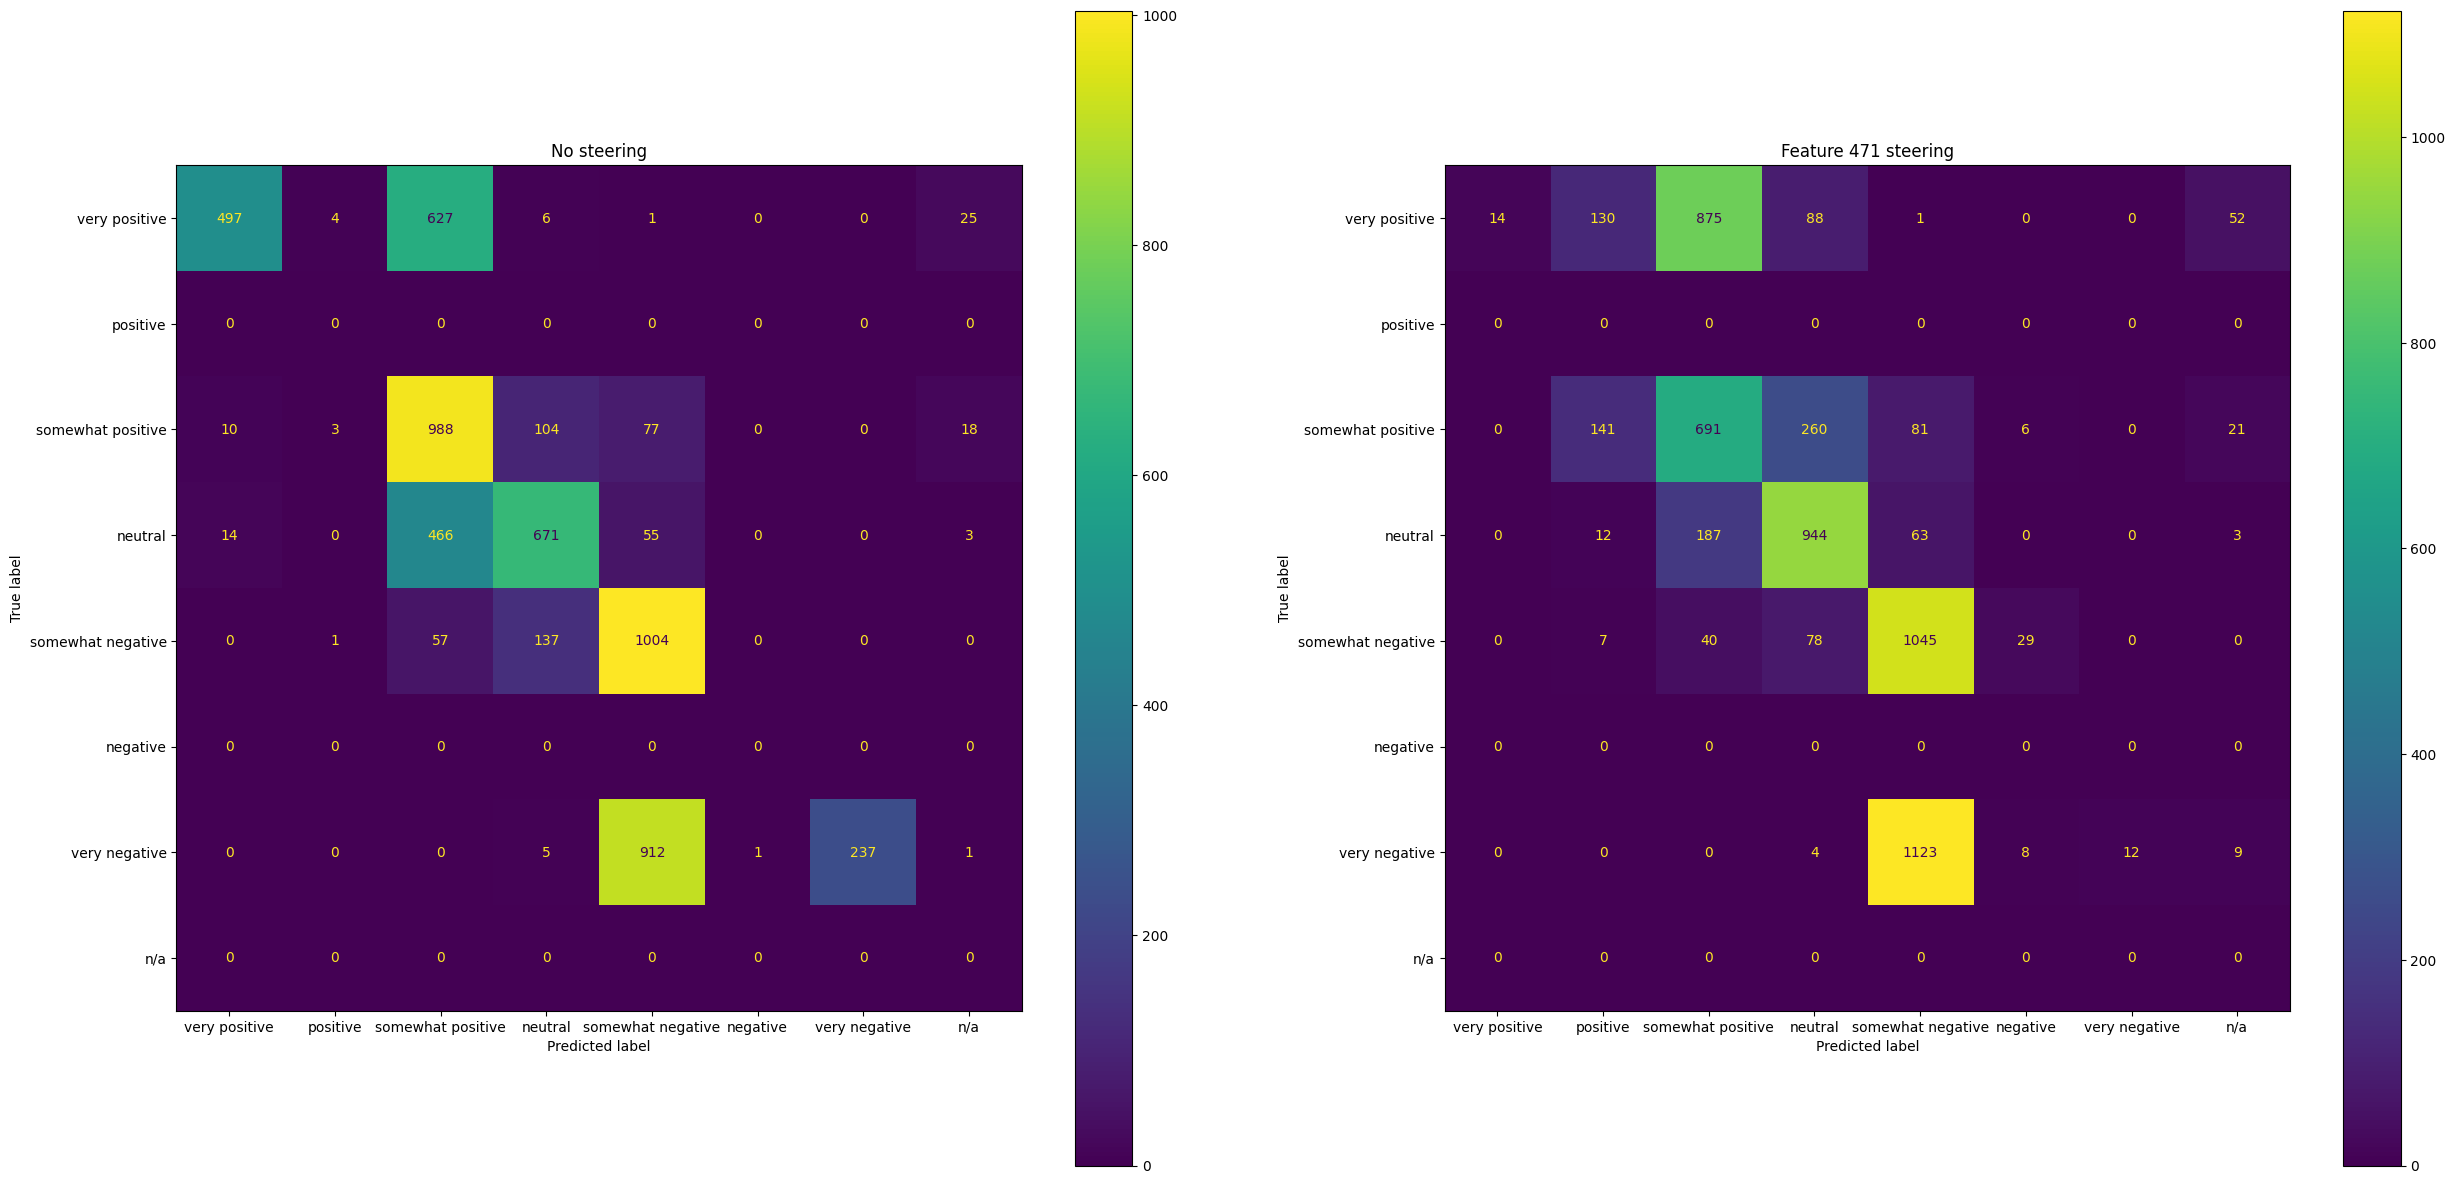

In [366]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))
axes[0].set_title('No steering')
axes[1].set_title('Feature 471 steering')
cfd1.plot(ax=axes[0])
cfd2.plot(ax=axes[1])
#fig.tight_layout()

In [148]:
pred.unique()

array(['very positive', 'positive', 'negative', 'very negative', 'n/a',
       'somewhat negative', 'neutral', 'somewhat positive'], dtype=object)

In [317]:
prompt = '<start_of_turn>user\nWhat is the meaning of the word "X"?<end_of_turn>\n<start_of_turn>model\nThe meaning of the word "X" is "'

# Find positions of the token "X" in the encoded prompt
positions = [i for i, a in enumerate(model.tokenizer.encode(prompt)) if model.tokenizer.decode([a]) == "X"]

# Generate new sequences based on the prompt
with model.generate(prompt, max_new_tokens=max_new_tokens, num_return_sequences=10, do_sample=True, scan=False, validate=False) as gen:
    # Normalize and scale the vector for the current feature
    vector = w_dec[[feature]]
    vector = vector / vector.norm()
    vector = vector * scale

    # Insert the vector into the model's output at the identified positions
    for position in positions:
        model.model.layers[2].output[0][:, position] = vector

    # Save the generated output
    out = model.generator.output.save()

# Initialize a local list to store explanations for the current feature
local = []

# Decode the generated output and extract the relevant part of the response

# Decode the generated output and extract the relevant part of the response
for i, l in enumerate(model.tokenizer.batch_decode(out)):
    local.append(repr(l.partition(prompt)[2].partition("<eos>")[0]))

print(local)

['\'a measure of the creditworthiness or financial strength of a person, company, or organization". It is a numerical rating from one to five, with higher numbers indicating lower risk and better credit. A company\'', '\'a measure of the creditworthiness or safety of an entity". In finance, a credit rating is an assessment of the financial strength and creditworthiness of a company or government. It is usually expressed by a\'', '\'an assessment of an entity\\\'s creditworthiness or financial stability". In other words, it is a measure of the entity\\\'s ability to repay its debts.\\n\\nIn finance, a credit rating is\'', '\'a evaluation or assessment of someone or something, usually by a professional." It is often used to indicate the financial worth, creditworthiness, or reliability of a person or organization.\'', '\'an assessment of the ability of an entity to repay a debt or obligation." A credit rating agency, such as Moody\\\'s or Standard & Poor\\\'s, assigns a credit rating to 